In [43]:
# !pip install opencv-python numpy matplotlib scikit-learn

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

In [45]:
# ==================== LOAD DỮ LIỆU TRAINING VÀ TRAIN KNN ====================
# (Thực hiện sớm để có model sẵn sàng cho bước nhận diện)
RESIZED_IMAGE_WIDTH = 20
RESIZED_IMAGE_HEIGHT = 30

print("Đang tải dữ liệu training...")
# Load dữ liệu từ file
classifications = np.loadtxt("classifications.txt", np.float32)
flattened_images = np.loadtxt("flattened_images.txt", np.float32)

# Reshape classifications thành vector 1D
classifications = classifications.reshape((classifications.size,))

print(f"✅ Đã tải {len(classifications)} mẫu training")
print(f"✅ Kích thước mỗi ảnh: {RESIZED_IMAGE_WIDTH}x{RESIZED_IMAGE_HEIGHT} = {RESIZED_IMAGE_WIDTH * RESIZED_IMAGE_HEIGHT} pixels")

# Train KNN model
print("\nĐang train KNN model...")
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(flattened_images, classifications)

print("✅ Đã train xong KNN model!")
print(f"✅ Số lớp: {len(np.unique(classifications))}")
print(f"✅ Các ký tự: {sorted([chr(int(c)) for c in np.unique(classifications)])}")

Đang tải dữ liệu training...
✅ Đã tải 160 mẫu training
✅ Kích thước mỗi ảnh: 20x30 = 600 pixels

Đang train KNN model...
✅ Đã train xong KNN model!
✅ Số lớp: 32
✅ Các ký tự: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'X', 'Y', 'Z']


In [46]:
# ==================== DỮ LIỆU ĐẦU VÀO VÀ THAM SỐ ====================
# ⚠️ THAY ĐỔI ĐƯỜNG DẪN NÀY SAU KHI UPLOAD ẢNH LÊN COLAB
IMAGE_PATH = 'bien_so_nghieng.jpg'

# Tọa độ 4 góc chuẩn hóa bạn cung cấp: [x1, y1, x2, y2, x3, y3, x4, y4]
# Sẽ được sắp xếp lại thành (TL, TR, BR, BL) trong hàm order_points_corrected
normalized_coords_raw = np.array([
    # Điểm 1: x=0.8665, y=0.1345
    [0.8665292390625, 0.13456756718750001],

    # Điểm 2: x=0.2476, y=0.1236
    [0.2476783625, 0.1236081078125],

    # Điểm 3: x=0.0340, y=0.7542
    [0.03405555625, 0.754216215625],

    # Điểm 4: x=0.6876, y=0.8606
    [0.6876491234375, 0.8606655406250001]
])
# ==================== HÀM TIỆN ÍCH: SẮP XẾP TỌA ĐỘ ====================
def order_points_corrected(pts):
    """
    Sắp xếp 4 điểm tọa độ theo thứ tự chuẩn: Trên-Trái, Trên-Phải, Dưới-Phải, Dưới-Trái (TL, TR, BR, BL).
    """
    pts = np.array(pts, dtype = "float32")
    rect = np.zeros((4, 2), dtype = "float32")

    # Trên-Trái (TL) có tổng nhỏ nhất, Dưới-Phải (BR) có tổng lớn nhất
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # Lấy 2 điểm còn lại
    remaining_pts = np.delete(pts, [np.argmin(s), np.argmax(s)], axis=0)

    # Trên-Phải (TR) có hiệu (x-y) nhỏ nhất, Dưới-Trái (BL) có hiệu lớn nhất
    remaining_diff = np.diff(remaining_pts, axis=1).flatten()

    rect[1] = remaining_pts[np.argmin(remaining_diff)] # TR
    rect[3] = remaining_pts[np.argmax(remaining_diff)] # BL

    return rect

# Sắp xếp tọa độ đầu vào
sorted_normalized_points = order_points_corrected(normalized_coords_raw)
print("Tọa độ 4 góc đã sắp xếp (TL, TR, BR, BL):")
print(sorted_normalized_points)
print("-" * 60)

# ==================== ĐỊNH NGHĨA HÀM PHÂN ĐOẠN KÝ TỰ ====================
def segment_characters_debug(img_rectified):
    """
    Phân đoạn ký tự bằng Ngưỡng Otsu và Phép Đóng (Morphological Closing).
    Hàm này thực hiện BƯỚC TÁCH PHÂN NGƯỠNG để tách các ký tự từ ảnh biển số.
    """
    if img_rectified is None:
        print("Lỗi: Không có ảnh đã làm thẳng để xử lý.")
        return []

    print("\n--- DEBUG: BƯỚC TIỀN XỬ LÝ (Otsu + Morphology) ---")
    gray = cv2.cvtColor(img_rectified, cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # 1. ÁP DỤNG NGƯỠNG OTSU (Chương 3.1.5 - Kỹ thuật tìm tách ngưỡng tự động)
    # Tự động tìm ngưỡng tối ưu - ĐÂY LÀ BƯỚC TÁCH PHÂN NGƯỠNG
    ret_otsu, binary = cv2.threshold(blurred, 0, 255,
                                    cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    print(f"Ngưỡng Otsu tự động tìm được: {ret_otsu}")

    plt.figure(figsize=(6, 3))
    plt.imshow(binary, cmap='gray')
    plt.title("Ảnh Nhị Phân (Sau Ngưỡng Otsu - BƯỚC TÁCH PHÂN NGƯỠNG)")
    plt.show()

    # 2. ÁP DỤNG PHÉP ĐÓNG (MORPH_CLOSE) (Chương 4.4.1)
    # Phép Đóng = Giãn (Dilate) rồi Co (Erode).
    # Mục đích: Nối liền các ký tự bị đứt gãy (do ngưỡng Otsu hoặc ảnh mờ).
    kernel = np.ones((3,3), np.uint8)
    binary_morphed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=1)

    plt.figure(figsize=(6, 3))
    plt.imshow(binary_morphed, cmap='gray')
    plt.title("Ảnh sau Phép Đóng (Nối liền ký tự)")
    plt.show()

    # --- BƯỚC B: TÌM & LỌC CONTOURS (trên ảnh đã Đóng) ---
    print("\n--- DEBUG: TÌM VÀ LỌC CONTOURS ---")
    contours, _ = cv2.findContours(binary_morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Tham số lọc (Điều chỉnh cho ảnh 400x400)
    MIN_W = 10      # Chiều rộng tối thiểu
    MAX_H = 180     # Chiều cao max (gần bằng chiều cao ảnh)
    MIN_H = 50      # Chiều cao min (loại bỏ dấu chấm/nhiễu)
    MIN_ASPECT = 0.1
    MAX_ASPECT = 0.9  # Nới lỏng cho ký tự 'V', 'M'

    char_contours = []
    debug_img_bgr = cv2.cvtColor(img_rectified.copy(), cv2.COLOR_RGB2BGR)

    for i, cnt in enumerate(contours):
        x, y, w, h = cv2.boundingRect(cnt)
        aspect_ratio = w / h if h > 0 else 0

        condition_w = w > MIN_W
        condition_h = h > MIN_H and h < MAX_H
        condition_aspect = aspect_ratio > MIN_ASPECT and aspect_ratio < MAX_ASPECT

        if h > 20: # Chỉ in log cho contour đáng kể
            print(f"Contour {i}: x={x}, y={y}, w={w}, h={h}, tỷ lệ (w/h)={aspect_ratio:.2f}")
            print(f"   -> Lọc W={condition_w}, Lọc H={condition_h}, Lọc Tỷ lệ={condition_aspect}")

        if condition_w and condition_h and condition_aspect:
             char_contours.append((x, y, w, h))
             cv2.rectangle(debug_img_bgr, (x, y), (x + w, y + h), (0, 255, 0), 2)
        else:
             cv2.rectangle(debug_img_bgr, (x, y), (x + w, y + h), (0, 0, 255), 1)

    # Sắp xếp theo Vị trí (x)
    char_contours = sorted(char_contours, key=lambda b: b[0])

    plt.figure(figsize=(10, 4))
    plt.imshow(cv2.cvtColor(debug_img_bgr, cv2.COLOR_BGR2RGB))
    plt.title(f"Contours được chấp nhận ({len(char_contours)} ký tự)")
    plt.show()

    # --- BƯỚC C: TRÍCH XUẤT KÝ TỰ (từ ảnh nhị phân GỐC sau tách phân ngưỡng) ---
    char_images = []
    if len(char_contours) > 0:
        print(f"\n✅ Đã trích xuất {len(char_contours)} vùng ký tự sau khi lọc.")
        plt.figure(figsize=(15, 3))
        for i, (x, y, w, h) in enumerate(char_contours):
            padding = 2
            # Cắt từ ảnh nhị phân GỐC (binary) - đã qua bước tách phân ngưỡng Otsu
            char_img = binary[max(0, y-padding):min(binary.shape[0], y+h+padding),
                              max(0, x-padding):min(binary.shape[1], x+w+padding)]

            char_images.append(char_img)

            plt.subplot(1, len(char_contours), i+1)
            plt.imshow(char_img, cmap='gray')
            plt.title(f"Ký tự {i+1}")
            plt.axis('off')
        plt.show()
    else:
        print("\n❌ Kết quả cuối cùng: Không trích xuất được ký tự nào hợp lệ.")

    return char_images

Tọa độ 4 góc đã sắp xếp (TL, TR, BR, BL):
[[0.24767837 0.1236081 ]
 [0.8665292  0.13456757]
 [0.68764913 0.86066556]
 [0.03405556 0.7542162 ]]
------------------------------------------------------------


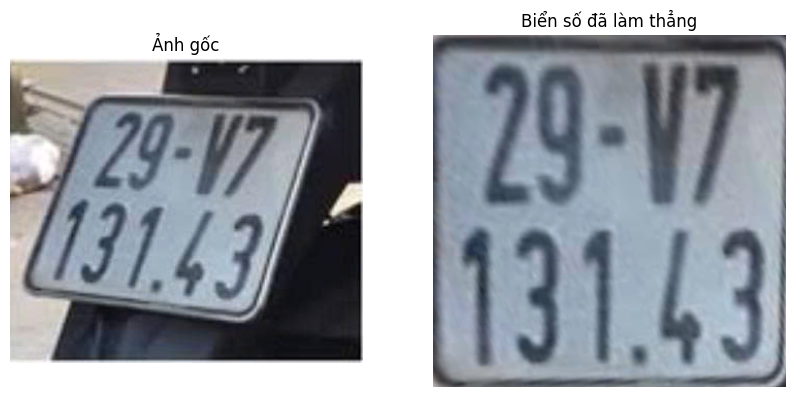

In [47]:
def rectify_license_plate(image_path, norm_points):
    """Làm thẳng biển số xe từ ảnh nghiêng sử dụng tọa độ chuẩn hóa."""
    img = cv2.imread(image_path)
    if img is None:
        print(f"❌ Lỗi: Không thể tải ảnh từ: {image_path}")
        return None, 0, 0

    # 1. Chuyển tọa độ chuẩn hóa sang tọa độ pixel
    H_img, W_img = img.shape[:2]
    pixel_points = norm_points.copy()
    pixel_points[:, 0] *= W_img
    pixel_points[:, 1] *= H_img
    input_pts = np.float32(pixel_points)

    # 2. Định nghĩa kích thước và tọa độ đích
    RECTIFIED_WIDTH = 400
    RECTIFIED_HEIGHT = 400

    output_pts = np.float32([
        [0, 0], [RECTIFIED_WIDTH - 1, 0],
        [RECTIFIED_WIDTH - 1, RECTIFIED_HEIGHT - 1], [0, RECTIFIED_HEIGHT - 1]
    ])

    # 3. Tính và Áp dụng ma trận biến đổi phối cảnh
    M = cv2.getPerspectiveTransform(input_pts, output_pts)
    # Chuyển đổi màu từ BGR sang RGB cho Matplotlib
    img_rectified = cv2.warpPerspective(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), M, (RECTIFIED_WIDTH, RECTIFIED_HEIGHT))

    # Hiển thị ảnh
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Ảnh gốc")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img_rectified)
    plt.title("Biển số đã làm thẳng")
    plt.axis('off')
    plt.show()

    return img_rectified, W_img, H_img

# Thực thi làm thẳng ảnh
img_rectified, W_img, H_img = rectify_license_plate(IMAGE_PATH, sorted_normalized_points)

In [48]:
def segment_characters_debug(img_rectified, show_debug=True):
    """
    Phân đoạn ký tự bằng Ngưỡng Otsu và Phép Đóng (Morphological Closing).
    
    Parameters:
    -----------
    img_rectified : numpy array
        Ảnh biển số đã được làm thẳng
    show_debug : bool
        Có hiển thị các ảnh debug không (mặc định: True)
    """
    if img_rectified is None:
        print("Lỗi: Không có ảnh đã làm thẳng để xử lý.")
        return []

    if show_debug:
        print("\n--- DEBUG: BƯỚC TIỀN XỬ LÝ (Threshold + Morphology) ---")
    gray = cv2.cvtColor(img_rectified, cv2.COLOR_RGB2GRAY)

    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # QUAN TRỌNG: Dữ liệu training sử dụng adaptiveThreshold
    # Để đảm bảo khớp format, ta có thể thử cả 2 phương pháp:
    # 1. Adaptive Threshold (giống training)
    binary_adaptive = cv2.adaptiveThreshold(blurred, 255,
                                           cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                           cv2.THRESH_BINARY_INV, 11, 2)
    
    # 2. Otsu Threshold (thường tốt hơn cho ảnh biển số)
    ret_otsu, binary_otsu = cv2.threshold(blurred, 0, 255,
                                          cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    if show_debug:
        print(f"Ngưỡng Otsu tự động tìm được: {ret_otsu}")
        print("Sử dụng Otsu Threshold (có thể đổi sang Adaptive Threshold nếu kết quả không tốt)")

    # Sử dụng Otsu (thường tốt hơn), nhưng có thể đổi sang adaptiveThreshold nếu cần
    binary = binary_otsu

    if show_debug:
        plt.figure(figsize=(6, 3))
        plt.imshow(binary, cmap='gray')
        plt.title("Ảnh Nhị Phân (Sau Ngưỡng Otsu)")
        plt.show()

    # 2. ÁP DỤNG PHÉP ĐÓNG (MORPH_CLOSE) (Chương 4.4.1)
    # Phép Đóng = Giãn (Dilate) rồi Co (Erode).
    # Mục đích: Nối liền các ký tự bị đứt gãy (do ngưỡng Otsu hoặc ảnh mờ).
    kernel = np.ones((3,3), np.uint8)
    binary_morphed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=1)

    if show_debug:
        plt.figure(figsize=(6, 3))
        plt.imshow(binary_morphed, cmap='gray')
        plt.title("Ảnh sau Phép Đóng (Nối liền ký tự)")
        plt.show()

    # --- BƯỚC B: TÌM & LỌC CONTOURS (trên ảnh đã Đóng) ---
    if show_debug:
        print("\n--- DEBUG: TÌM VÀ LỌC CONTOURS ---")
    contours, _ = cv2.findContours(binary_morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Tham số lọc (Điều chỉnh cho ảnh 400x200)
    MIN_W = 10      # Chiều rộng tối thiểu
    MAX_H = 180     # Chiều cao max (gần bằng chiều cao ảnh)
    MIN_H = 50      # Chiều cao min (loại bỏ dấu chấm/nhiễu)
    MIN_ASPECT = 0.1
    MAX_ASPECT = 0.9  # Nới lỏng cho ký tự 'V', 'M'

    char_contours = []
    debug_img_bgr = cv2.cvtColor(img_rectified.copy(), cv2.COLOR_RGB2BGR)

    for i, cnt in enumerate(contours):
        x, y, w, h = cv2.boundingRect(cnt)
        aspect_ratio = w / h

        condition_w = w > MIN_W
        condition_h = h > MIN_H and h < MAX_H
        condition_aspect = aspect_ratio > MIN_ASPECT and aspect_ratio < MAX_ASPECT

        if show_debug and h > 20: # Chỉ in log cho contour đáng kể
            print(f"Contour {i}: x={x}, y={y}, w={w}, h={h}, tỷ lệ (w/h)={aspect_ratio:.2f}")
            print(f"   -> Lọc W={condition_w}, Lọc H={condition_h}, Lọc Tỷ lệ={condition_aspect}")

        if condition_w and condition_h and condition_aspect:
             char_contours.append((x, y, w, h))
             cv2.rectangle(debug_img_bgr, (x, y), (x + w, y + h), (0, 255, 0), 2)
        else:
             cv2.rectangle(debug_img_bgr, (x, y), (x + w, y + h), (0, 0, 255), 1)

    # Sắp xếp theo Vị trí (x)
    char_contours = sorted(char_contours, key=lambda b: b[0])

    plt.figure(figsize=(10, 4))
    plt.imshow(cv2.cvtColor(debug_img_bgr, cv2.COLOR_BGR2RGB))
    plt.title(f"Contours được chấp nhận ({len(char_contours)} ký tự)")
    plt.show()

    # --- BƯỚC C: TRÍCH XUẤT KÝ TỰ (từ ảnh nhị phân GỐC) ---
    char_images = []
    if len(char_contours) > 0:
        print(f"\n✅ Đã trích xuất {len(char_contours)} vùng ký tự sau khi lọc.")
        plt.figure(figsize=(15, 3))
        for i, (x, y, w, h) in enumerate(char_contours):
            padding = 2
            # Cắt từ ảnh nhị phân GỐC (binary)
            char_img = binary[max(0, y-padding):min(binary_morphed.shape[0], y+h+padding),
                              max(0, x-padding):min(binary_morphed.shape[1], x+w+padding)]

            char_images.append(char_img)

            plt.subplot(1, len(char_contours), i+1)
            plt.imshow(char_img, cmap='gray')
            plt.title(f"Ký tự {i+1}")
            plt.axis('off')
        plt.show()
    else:
        print("\n❌ Kết quả cuối cùng: Không trích xuất được ký tự nào hợp lệ.")

    return char_images

# Lưu ý: Hàm segment_characters_debug đã được định nghĩa ở cell 3
# Việc gọi hàm để phân đoạn ký tự (tách phân ngưỡng) sẽ được thực hiện ở cell 5


BƯỚC 1: CHIA ẢNH VÀ PHÂN ĐOẠN KÝ TỰ - TÁCH PHÂN NGƯỠNG


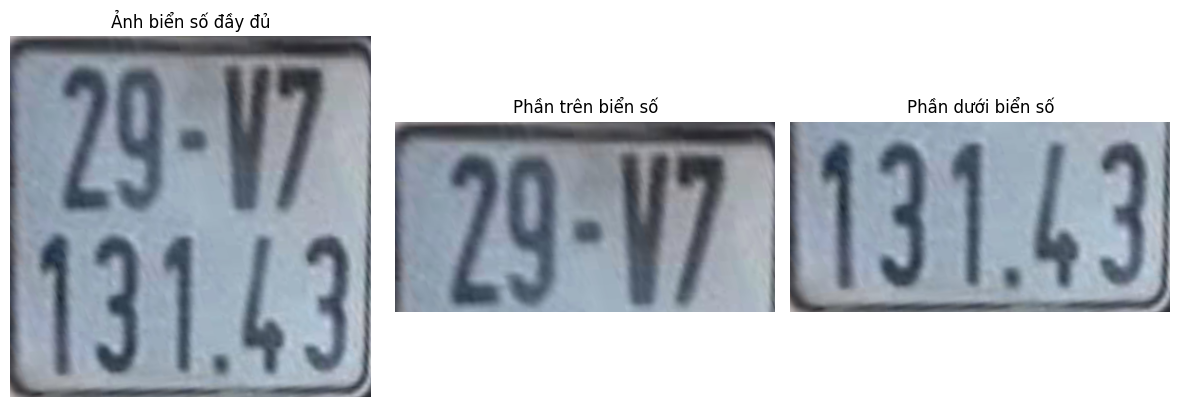


✅ Đã chia ảnh thành 2 phần:
   - Phần trên: 200x400 pixels
   - Phần dưới: 200x400 pixels

--- PHÂN ĐOẠN KÝ TỰ PHẦN TRÊN ---


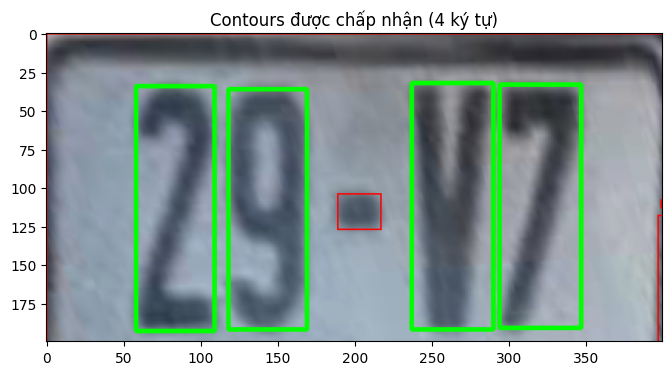


✅ Đã trích xuất 4 vùng ký tự sau khi lọc.


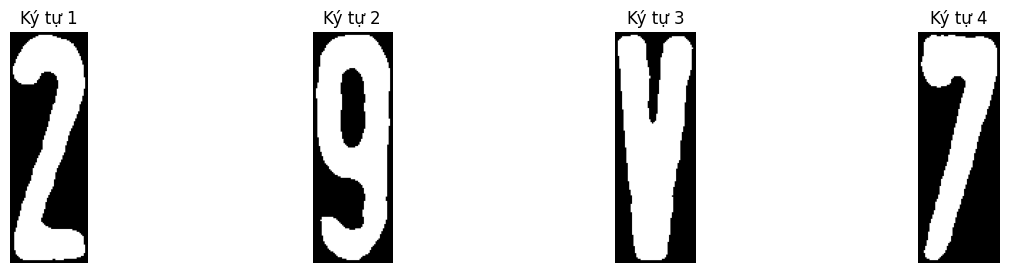

✅ Đã phân đoạn được 4 ký tự từ phần trên

--- PHÂN ĐOẠN KÝ TỰ PHẦN DƯỚI ---


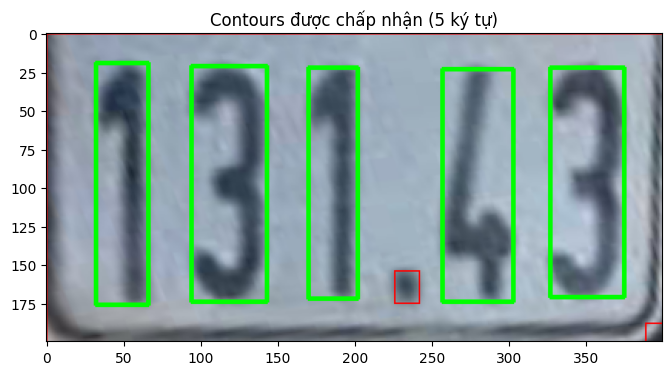


✅ Đã trích xuất 5 vùng ký tự sau khi lọc.


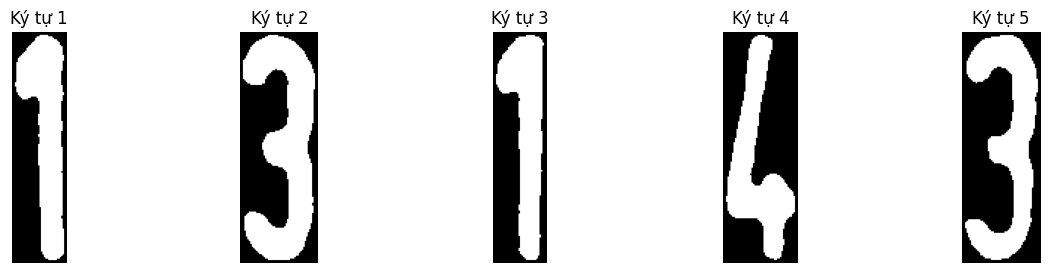

✅ Đã phân đoạn được 5 ký tự từ phần dưới


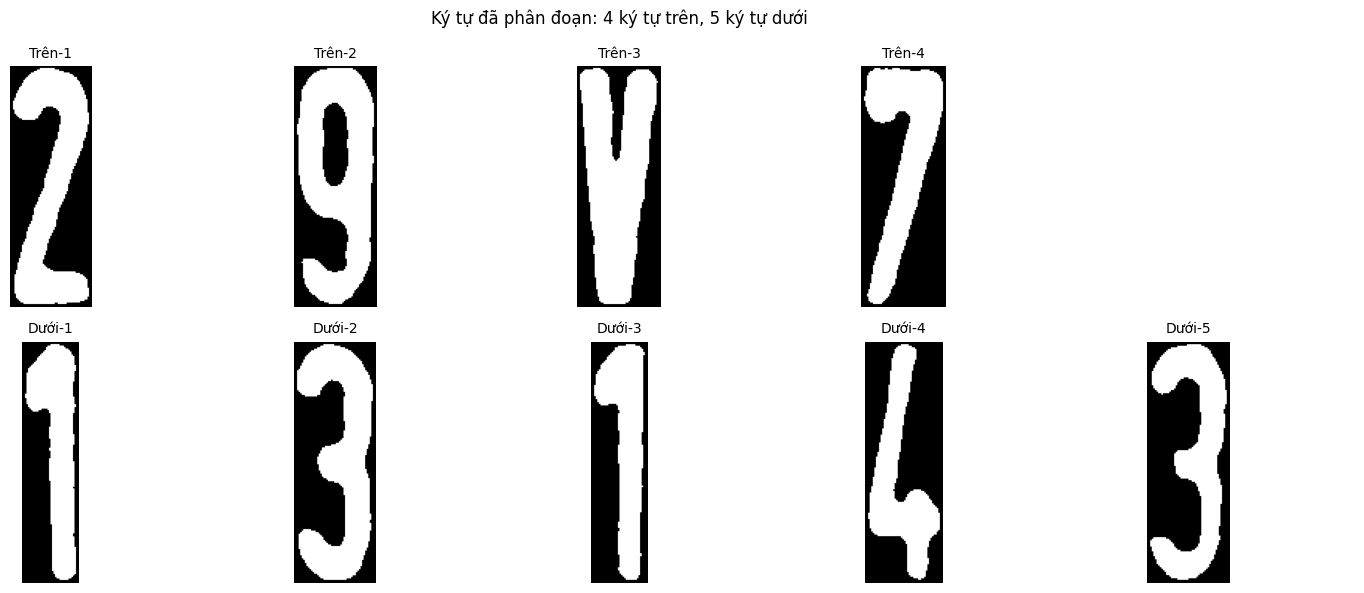


✅ Tổng cộng đã phân đoạn được 9 ký tự:
   - Phần trên: 4 ký tự
   - Phần dưới: 5 ký tự


In [49]:
# ==================== PHÂN ĐOẠN KÝ TỰ (TÁCH PHÂN NGƯỠNG) ====================
# BƯỚC QUAN TRỌNG: Chia ảnh biển số thành 2 phần (trên và dưới)
# Sau đó phân đoạn ký tự từng phần riêng biệt
print("\n" + "="*60)
print("BƯỚC 1: CHIA ẢNH VÀ PHÂN ĐOẠN KÝ TỰ - TÁCH PHÂN NGƯỠNG")
print("="*60)

# Chia ảnh biển số thành 2 phần: trên và dưới
H, W = img_rectified.shape[:2]
split_y = H // 2  # Chia đôi theo chiều dọc

img_top = img_rectified[0:split_y, :]      # Phần trên
img_bottom = img_rectified[split_y:, :]    # Phần dưới

# Hiển thị 2 phần đã chia
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(img_rectified)
plt.title("Ảnh biển số đầy đủ")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img_top)
plt.title("Phần trên biển số")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(img_bottom)
plt.title("Phần dưới biển số")
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"\n✅ Đã chia ảnh thành 2 phần:")
print(f"   - Phần trên: {img_top.shape[0]}x{img_top.shape[1]} pixels")
print(f"   - Phần dưới: {img_bottom.shape[0]}x{img_bottom.shape[1]} pixels")

# Phân đoạn ký tự từ phần trên
print("\n--- PHÂN ĐOẠN KÝ TỰ PHẦN TRÊN ---")
char_images_top = segment_characters_debug(img_top, show_debug=False)
print(f"✅ Đã phân đoạn được {len(char_images_top)} ký tự từ phần trên")

# Phân đoạn ký tự từ phần dưới
print("\n--- PHÂN ĐOẠN KÝ TỰ PHẦN DƯỚI ---")
char_images_bottom = segment_characters_debug(img_bottom, show_debug=False)
print(f"✅ Đã phân đoạn được {len(char_images_bottom)} ký tự từ phần dưới")

# Hiển thị tất cả ký tự đã phân đoạn
if len(char_images_top) > 0 or len(char_images_bottom) > 0:
    total_chars = len(char_images_top) + len(char_images_bottom)
    max_chars = max(len(char_images_top), len(char_images_bottom), 1)
    
    fig, axes = plt.subplots(2, max_chars, figsize=(max(15, max_chars * 2), 6))
    if max_chars == 1:
        axes = axes.reshape(2, 1)
    
    # Hiển thị ký tự phần trên
    for i in range(len(char_images_top)):
        axes[0, i].imshow(char_images_top[i], cmap='gray')
        axes[0, i].set_title(f"Trên-{i+1}", fontsize=10)
        axes[0, i].axis('off')
    # Ẩn các subplot không sử dụng
    for i in range(len(char_images_top), max_chars):
        axes[0, i].axis('off')
    
    # Hiển thị ký tự phần dưới
    for i in range(len(char_images_bottom)):
        axes[1, i].imshow(char_images_bottom[i], cmap='gray')
        axes[1, i].set_title(f"Dưới-{i+1}", fontsize=10)
        axes[1, i].axis('off')
    # Ẩn các subplot không sử dụng
    for i in range(len(char_images_bottom), max_chars):
        axes[1, i].axis('off')
    
    plt.suptitle(f"Ký tự đã phân đoạn: {len(char_images_top)} ký tự trên, {len(char_images_bottom)} ký tự dưới", 
                fontsize=12, y=0.98)
    plt.tight_layout()
    plt.show()

# Kết hợp tất cả ký tự (trên trước, dưới sau)
char_images = char_images_top + char_images_bottom
char_images_info = [('top', i) for i in range(len(char_images_top))] + \
                   [('bottom', i) for i in range(len(char_images_bottom))]

print(f"\n✅ Tổng cộng đã phân đoạn được {len(char_images)} ký tự:")
print(f"   - Phần trên: {len(char_images_top)} ký tự")
print(f"   - Phần dưới: {len(char_images_bottom)} ký tự")



BƯỚC 2: NHẬN DIỆN KÝ TỰ BẰNG KNN

--- NHẬN DIỆN 9 KÝ TỰ ---
Ký tự 1: '2' (ASCII: 50)
   -> Độ tin cậy: 0.00% (Vote: 0/3, Khoảng cách TB: 1758.9)
Ký tự 2: '9' (ASCII: 57)
   -> Độ tin cậy: 0.00% (Vote: 0/3, Khoảng cách TB: 1861.8)
Ký tự 3: 'V' (ASCII: 86)
   -> Độ tin cậy: 0.00% (Vote: 0/3, Khoảng cách TB: 2078.2)
Ký tự 4: '7' (ASCII: 55)
   -> Độ tin cậy: 0.00% (Vote: 0/3, Khoảng cách TB: 1758.1)
Ký tự 5: '1' (ASCII: 49)
   -> Độ tin cậy: 0.00% (Vote: 0/3, Khoảng cách TB: 1931.1)
Ký tự 6: '3' (ASCII: 51)
   -> Độ tin cậy: 0.00% (Vote: 0/3, Khoảng cách TB: 1974.7)
Ký tự 7: '1' (ASCII: 49)
   -> Độ tin cậy: 0.00% (Vote: 0/3, Khoảng cách TB: 1964.3)
Ký tự 8: '4' (ASCII: 52)
   -> Độ tin cậy: 0.00% (Vote: 0/3, Khoảng cách TB: 1843.3)
Ký tự 9: '3' (ASCII: 51)
   -> Độ tin cậy: 0.00% (Vote: 0/3, Khoảng cách TB: 1932.0)


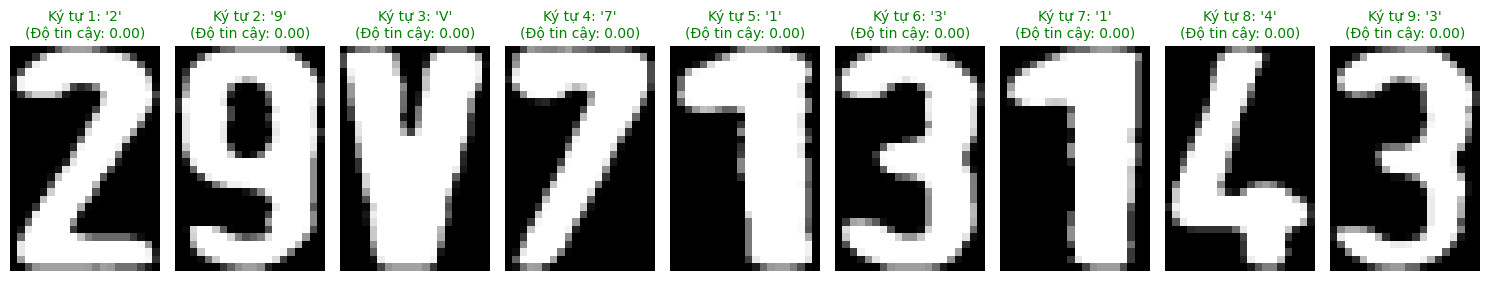


🎯 BIỂN SỐ XE NHẬN DIỆN ĐƯỢC:
Dòng trên: 29V7
Dòng dưới: 13143


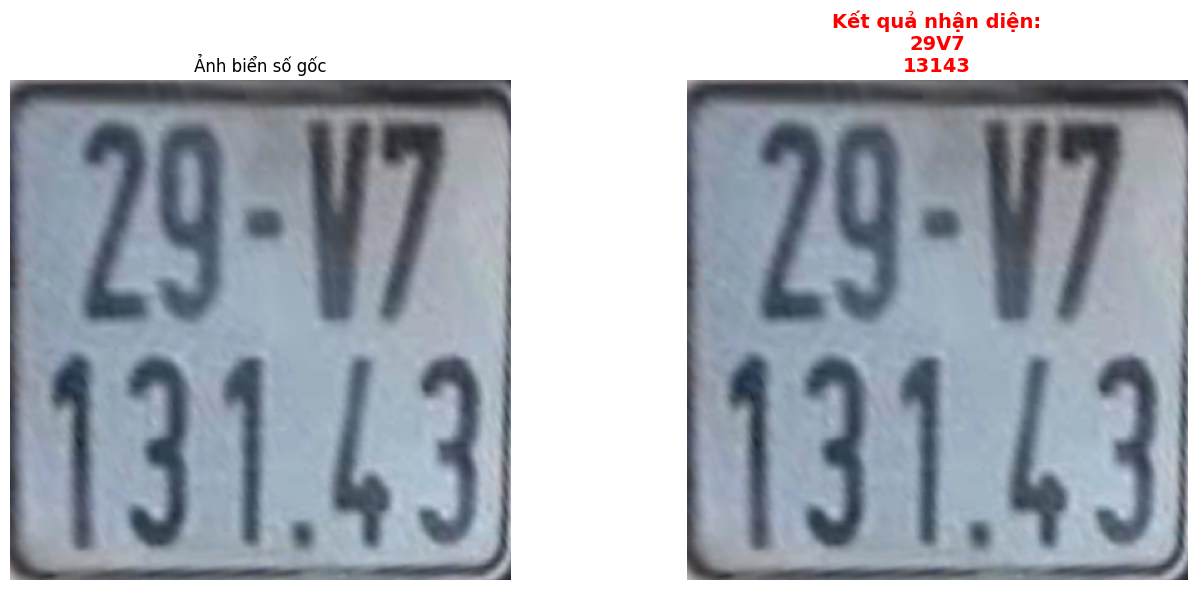

In [50]:
# ==================== NHẬN DIỆN KÝ TỰ TỪ BIỂN SỐ ====================
# BƯỚC 2: NHẬN DIỆN KÝ TỰ (SAU BƯỚC TÁCH PHÂN NGƯỠNG)
# Sử dụng các ký tự đã được tách ra từ bước phân ngưỡng Otsu ở cell trước
print("\n" + "="*60)
print("BƯỚC 2: NHẬN DIỆN KÝ TỰ BẰNG KNN")
print("="*60)

def preprocess_char_image(char_img, target_width=20, target_height=30):
    """
    Tiền xử lý ảnh ký tự: resize trực tiếp giống như dữ liệu training.
    QUAN TRỌNG: Phải giống hệt cách xử lý trong quá trình tạo dữ liệu training.
    """
    # Đảm bảo ảnh là nhị phân (0 hoặc 255) và là uint8
    if char_img.max() <= 1:
        char_img = (char_img * 255).astype(np.uint8)
    else:
        char_img = char_img.astype(np.uint8)
    
    # Resize trực tiếp về kích thước đích (giống như training)
    # Training sử dụng: cv2.resize(imgROI, (RESIZED_IMAGE_WIDTH, RESIZED_IMAGE_HEIGHT))
    char_resized = cv2.resize(char_img, (target_width, target_height), interpolation=cv2.INTER_AREA)
    
    return char_resized

def recognize_characters(char_images, knn_model):
    """
    Nhận diện các ký tự từ danh sách ảnh ký tự đã phân đoạn.
    """
    if len(char_images) == 0:
        print("❌ Không có ký tự nào để nhận diện!")
        return []
    
    recognized_chars = []
    
    print(f"\n--- NHẬN DIỆN {len(char_images)} KÝ TỰ ---")
    
    plt.figure(figsize=(15, 3))
    
    for i, char_img in enumerate(char_images):
        # Tiền xử lý ảnh ký tự
        char_processed = preprocess_char_image(char_img, RESIZED_IMAGE_WIDTH, RESIZED_IMAGE_HEIGHT)
        
        # Flatten thành vector 1D (giống hệt cách training)
        char_flattened = char_processed.reshape((1, RESIZED_IMAGE_WIDTH * RESIZED_IMAGE_HEIGHT))
        
        # Chuyển sang float32 để phù hợp với dữ liệu training
        # QUAN TRỌNG: Dữ liệu training lưu dưới dạng float32 với giá trị 0-255
        char_flattened = char_flattened.astype(np.float32)
        
        # Đảm bảo giá trị trong khoảng [0, 255] (không normalize về [0, 1])
        # Vì dữ liệu training được lưu với giá trị 0-255
        
        # Dự đoán bằng KNN
        prediction = knn_model.predict(char_flattened)
        predicted_char = chr(int(prediction[0]))
        
        # Tính độ tin cậy dựa trên:
        # 1. Tỷ lệ vote của các neighbors cùng class
        # 2. Khoảng cách trung bình đến các neighbors
        distances, indices = knn_model.kneighbors(char_flattened, n_neighbors=3)
        
        # Lấy labels của training data tại các vị trí indices
        # knn_model có thuộc tính _y chứa labels của training data
        training_labels = knn_model._y if hasattr(knn_model, '_y') else classifications
        neighbor_labels = training_labels[indices[0]]  # Lấy labels của các neighbors
        
        # Đếm số neighbors cùng class với prediction
        same_class_count = np.sum(neighbor_labels == prediction[0])
        vote_ratio = same_class_count / len(neighbor_labels)  # Tỷ lệ vote
        
        # Tính độ tin cậy dựa trên vote ratio và khoảng cách
        avg_distance = np.mean(distances[0])
        max_possible_distance = np.sqrt(RESIZED_IMAGE_WIDTH * RESIZED_IMAGE_HEIGHT) * 255  # Ước tính max distance
        normalized_distance = min(avg_distance / max_possible_distance, 1.0)  # Chuẩn hóa về [0, 1]
        
        # Confidence = vote_ratio * (1 - normalized_distance * weight)
        # Nếu tất cả neighbors cùng class và khoảng cách nhỏ → confidence cao
        confidence = vote_ratio * (1.0 - normalized_distance * 0.3)
        confidence = max(0.0, min(1.0, confidence))  # Đảm bảo trong [0, 1]
        
        recognized_chars.append(predicted_char)
        
        # Hiển thị kết quả
        plt.subplot(1, len(char_images), i + 1)
        plt.imshow(char_processed, cmap='gray')
        plt.title(f"Ký tự {i+1}: '{predicted_char}'\n(Độ tin cậy: {confidence:.2f})", 
                 fontsize=10, color='green')
        plt.axis('off')
        
        print(f"Ký tự {i+1}: '{predicted_char}' (ASCII: {ord(predicted_char)})")
        print(f"   -> Độ tin cậy: {confidence:.2%} (Vote: {same_class_count}/{len(neighbor_labels)}, Khoảng cách TB: {avg_distance:.1f})")
    
    plt.tight_layout()
    plt.show()
    
    return recognized_chars

# Thực thi nhận diện (sử dụng các ký tự đã được tách từ bước phân ngưỡng Otsu)
if 'char_images' in locals() and len(char_images) > 0:
    recognized_chars = recognize_characters(char_images, knn)
    
    # Nhóm ký tự theo phần (trên/dưới)
    if 'char_images_info' in locals() and len(recognized_chars) == len(char_images_info):
        # Nhóm ký tự theo phần
        top_chars = []
        bottom_chars = []
        
        for i, (part, idx) in enumerate(char_images_info):
            if part == 'top':
                top_chars.append(recognized_chars[i])
            else:
                bottom_chars.append(recognized_chars[i])
        
        # Kết hợp thành biển số đúng (trên + dưới)
        license_plate_top = ''.join(top_chars)
        license_plate_bottom = ''.join(bottom_chars)
        license_plate_text = f"{license_plate_top}\n{license_plate_bottom}"
        
        print(f"\n{'='*60}")
        print(f"🎯 BIỂN SỐ XE NHẬN DIỆN ĐƯỢC:")
        print(f"Dòng trên: {license_plate_top}")
        print(f"Dòng dưới: {license_plate_bottom}")
        print(f"{'='*60}")
        
        # Vẽ kết quả lên ảnh biển số đã làm thẳng
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        axes[0].imshow(img_rectified)
        axes[0].set_title("Ảnh biển số gốc", fontsize=12)
        axes[0].axis('off')
        
        axes[1].imshow(img_rectified)
        axes[1].set_title(f"Kết quả nhận diện:\n{license_plate_text}", 
                         fontsize=14, color='red', weight='bold')
        axes[1].axis('off')
        
        plt.tight_layout()
        plt.show()
    else:
        # Nếu không có thông tin phần, chỉ hiển thị kết quả đơn giản
        license_plate_text = ''.join(recognized_chars)
        print(f"\n{'='*60}")
        print(f"🎯 BIỂN SỐ XE NHẬN DIỆN ĐƯỢC: {license_plate_text}")
        print(f"{'='*60}")
        
        plt.figure(figsize=(12, 6))
        plt.imshow(img_rectified)
        plt.title(f"Kết quả nhận diện: {license_plate_text}", 
                 fontsize=14, color='red', weight='bold')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
else:
    print("❌ Lỗi: Chưa có ký tự nào được phân đoạn. Hãy chạy cell phân đoạn ký tự trước!")
    recognized_chars = []


In [51]:
# MIN_CONTOUR_AREA = 40


# RESIZED_IMAGE_WIDTH = 20
# RESIZED_IMAGE_HEIGHT = 30

# def genData():
#     imgTrainingNumbers = cv2.imread("training_chars.png")            # read in training numbers image
#     #imgTrainingNumbers = cv2.resize(imgTrainingNumbers, dsize = None, fx = 0.5, fy = 0.5)

#     # Add a check to see if the image was loaded successfully
#     if imgTrainingNumbers is None:
#         print("Error: Could not load training_chars.png. Make sure the file exists in the correct directory.")
#         return

#     imgGray = cv2.cvtColor(imgTrainingNumbers, cv2.COLOR_BGR2GRAY)          # get grayscale image
#     imgBlurred = cv2.GaussianBlur(imgGray, (5,5), 0)                        # blur

#                                                         # filter image from grayscale to black and white
#     imgThresh = cv2.adaptiveThreshold(imgBlurred,                           # input image
#                                       255,                                  # make pixels that pass the threshold full white
#                                       cv2.ADAPTIVE_THRESH_GAUSSIAN_C,       # use gaussian rather than mean, seems to give better results
#                                       cv2.THRESH_BINARY_INV,                # invert so foreground will be white, background will be black
#                                       11,                                   # size of a pixel neighborhood used to calculate threshold value
#                                       2)                                    # constant subtracted from the mean or weighted mean

#     from google.colab.patches import cv2_imshow
#     cv2_imshow(imgThresh)      # show threshold image for reference

#     imgThreshCopy = imgThresh.copy()        # make a copy of the thresh image, this in necessary b/c findContours modifies the image

#     npaContours, hierarchy = cv2.findContours(imgThreshCopy,        # input image, make sure to use a copy since the function will modify this image in the course of finding contours
#                                                  cv2.RETR_EXTERNAL,                 # retrieve the outermost contours only
#                                                  cv2.CHAIN_APPROX_SIMPLE)           # compress horizontal, vertical, and diagonal segments and leave only their end points

#                                 # declare empty numpy array, we will use this to write to file later
#                                 # zero rows, enough cols to hold all image data
#     npaFlattenedImages =  np.empty((0, RESIZED_IMAGE_WIDTH * RESIZED_IMAGE_HEIGHT))


#     intClassifications = []         # declare empty classifications list, this will be our list of how we are classifying our chars from user input, we will write to file at the end

#                                     # possible chars we are interested in are digits 0 through 9, put these in list intValidChars
#     intValidChars = [ord('0'), ord('1'), ord('2'), ord('3'), ord('4'), ord('5'), ord('6'), ord('7'), ord('8'), ord('9'),
#                      ord('A'), ord('B'), ord('C'), ord('D'), ord('E'), ord('F'), ord('G'), ord('H'), ord('I'), ord('J'),
#                      ord('K'), ord('L'), ord('M'), ord('N'), ord('O'), ord('P'), ord('Q'), ord('R'), ord('S'), ord('T'),
#                      ord('U'), ord('V'), ord('W'), ord('X'), ord('Y'), ord('Z')] #Là mã ascii của mấy chữ này

#     for npaContour in npaContours:                          # for each contour
#         if cv2.contourArea(npaContour) > MIN_CONTOUR_AREA:          # if contour is big enough to consider
#             [intX, intY, intW, intH] = cv2.boundingRect(npaContour)         # get and break out bounding rect

#                                                 # draw rectangle around each contour as we ask user for input
#             cv2.rectangle(imgTrainingNumbers,           # draw rectangle on original training image
#                           (intX, intY),                 # upper left corner
#                           (intX+intW,intY+intH),        # lower right corner
#                           (0, 0, 255),                  # red
#                           2)                            # thickness

#             imgROI = imgThresh[intY:intY+intH, intX:intX+intW]                                  # crop char out of threshold image
#             imgROIResized = cv2.resize(imgROI, (RESIZED_IMAGE_WIDTH, RESIZED_IMAGE_HEIGHT))     # resize image, this will be more consistent for recognition and storage

#             cv2_imshow(imgROI)                    # show cropped out char for reference
#             cv2_imshow(imgROIResized)      # show resized image for reference

#             cv2_imshow(imgTrainingNumbers)      # show training numbers image, this will now have red rectangles drawn on it

#             intChar = cv2.waitKey(0)                     # get key press

#             if intChar == 27:                   # if esc key was pressed
#                 sys.exit()                      # exit program
#             elif intChar in intValidChars:      # else if the char is in the list of chars we are looking for . . .

#                 intClassifications.append(intChar)        # append classification char to integer list of chars (we will convert to float later before writing to file)
#                 #Là file chứa label của tất cả các ảnh mẫu, tổng cộng có 32 x 5 = 160 mẫu.
#                 npaFlattenedImage = imgROIResized.reshape((1, RESIZED_IMAGE_WIDTH * RESIZED_IMAGE_HEIGHT))  # flatten image to 1d numpy array so we can write to file later

#                 npaFlattenedImages = np.append(npaFlattenedImages, npaFlattenedImage, 0)                    # add current flattened impage numpy array to list of flattened image numpy arrays

#             # end if
#         # end if
#     # end for

#     fltClassifications = np.array(intClassifications, np.float32)                   # convert classifications list of ints to numpy array of floats

#     npaClassifications = fltClassifications.reshape((fltClassifications.size, 1))   # flatten numpy array of floats to 1d so we can write to file later

#     print ("\n\ntraining complete !!\n")

#     np.savetxt("classifications.txt", npaClassifications)           # write flattened images to file
#     np.savetxt("flattened_images.txt", npaFlattenedImages)          #

#     cv2.destroyAllWindows()             # remove windows from memory

#     return


# genData()